#  Demo:  Specrum plot of a monthly timeseries 

+ author  : Stephanie Leroux, IGE, MEOM
+ date    : Feb 2017
+ purpose : Simple example of how to plot a time-spectrum from a monthly timeseries
+ -
+ *[Extra packages]*:  Extra packages to install: rpy2 (via conda) and pyclim () 
+ -
+ YOU CAN DOWNLOAD THE EXAMPLE DATASET IN THE SAME DIRECTORY: data.M.demo.pkl

###  1. Define a LOESS detrending function `loess_detrend()` :

In [1]:
#import math
import numpy as np
#import numpy.fft as fft
#import numpy.ma as ma
#from scipy.stats import sem
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri
# Since rpy2 version 2.3, it is necessary to activate the automatic 
# conversion from numpy to R arrays
if hasattr(rpy2.robjects.numpy2ri, 'activate'):
   rpy2.robjects.numpy2ri.activate()

################################################
################################################
def loess_detrend(ts, time, wgts, span=0.99, degree=2):
    """ loess detrending inspired from Guillaume Serrazin's tools
        Uses R package for Python
        This loess filter is set for parameters (spann 0.99, degree=2) that
        are equivalent to a HP filter of cutoff period = half the total time-segment.
        
        Note: wgts is a vector containing the weights to apply on the operator for each time-step. T
        he normal usage is to set wgts to 0.   Ex:  wgts = np.ones(len(data) ). But sometimes you might
        need to impose that the first time step of the timeseries (data[0]) should be invariant through 
        the loess operator. In that case, just set the first weight to a high number. Ex: wgts[0]=1000.  
    """
    rloess = robjects.r['loess']
    fmla = robjects.Formula('y ~ x')
    env = fmla.environment
    env['x'] = time
    env['y'] = ts
    ts_dtr = np.array(rloess(fmla, span=span, degree=degree, weights=wgts)[2])
    return ts_dtr
 


### 2. Read some example monthly data, detrend and filter it:

In [2]:
%matplotlib notebook
%matplotlib inline

import os, user, sys
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pickle
import numpy as np
import pyClim.filTools as filt


# Read df (which is a pandas dataframe)
diridat  = "./"
fili     = 'data.M.demo.pkl'
df       = pd.read_pickle(diridat+fili)

# Take the first column as a numpy vector and plot:
datats   = np.array(df["m01"])


# Set all weights to 0
wgts = np.ones(datats.shape[0])   

# Apply the loess detrending operator:
datats_dt = loess_detrend(datats, \
                   np.array(range(0,datats.shape[0],1)), wgts, \
                   span=0.99, degree=2) 

# Set filtering parameters:
# note1: for more info about the lanczos filter, see the documentation with filt.lanczos?


# sampling of the timeseries (in time units, e.g. yrs, months, etc)
Tech=1.   # ex: 1mo

# filtering cutoff (in time units)
Tc=12.*6.   # ex: cutoff at 6yrs (so Tc=12*6 in months)

# Half size of the filtering window (take at least Tc/Tech)
Nw=Tc/Tech


# type of filter: 'lp' for low-pass
fity='lp'  
#fity='hp'

# compute the lanczos coefficients
lop10=filt.lanczos(fity,Nw,Tech/Tc)

# apply the filtering operator (note: remember to remove the time mean before filtering)
datats_dt_filt = datats_dt*0.
datats_dt_filt = lop10.do_filtering1d(datats_dt-datats_dt.mean(),output='same')



/Users/leroux31/anaconda2/envs/pyn_test/lib/python2.7/site-packages/pyClim/filTools.py:299: RuntimeWarning: invalid value encountered in divide
  np.sin(pi * k / n) / (pi * k / n))
/Users/leroux31/anaconda2/envs/pyn_test/lib/python2.7/site-packages/pyClim/filTools.py:301: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  w[n] = 2 * fc


### 3.  Apply fourier transform (get periodigram) 

In [3]:
import quantecon as qe
import scipy.signal as signal


seglen=672
NPADDING = 2
winsp='boxcar'
smoolen = 15  # even
scaling='density'
#scaling='spectrum'

# apply on initial data (detrended)
fff, ppp = signal.periodogram(datats_dt, fs=1, window=winsp,nfft=NPADDING*seglen,scaling=scaling)

# apply on filtered data
fff_filt, ppp_filt = signal.periodogram(datats_dt_filt, fs=1, window=winsp,nfft=NPADDING*seglen,scaling=scaling)

# (optional: compute a smoothed version of the periodigram) 
ppp_smoothed = qe.smooth(ppp,window_len=smoolen,window='hanning')
ppp_filt_smoothed = qe.smooth(ppp_filt,window_len=smoolen,window='hanning')


### 4. Plot spectrum with matplotlib

In [18]:
################################################
# FUNCTION DEFS
################################################    

def tick_function(Y):
    V = 1./Y
    return ["%.1f" % z for z in V]

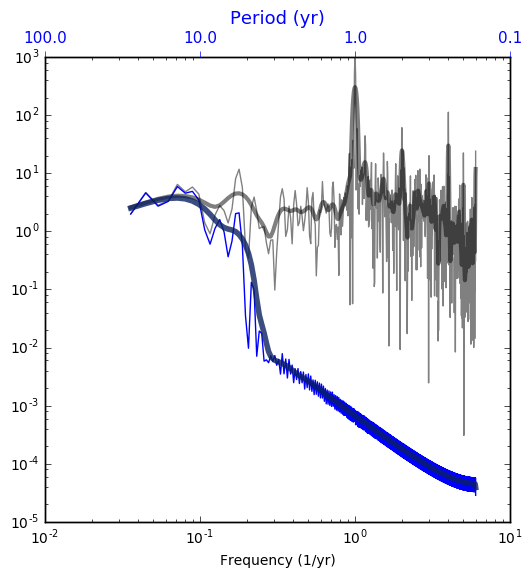

In [30]:
import pyClim.ploTools as ploT

## in order to NOT plot spectrum beyond the spectral resolution imposed by the detrending: i.e. Tc=28 yrs because the total timeseries is 56 yr long
nff = ( np.abs((1./(12.*fff))-28.)).argmin() 

## in order to convert time units from month to year on x axis
motoyr = 12.

       
plt.close('all')  
xlim=[1e-1, 1e1]
ylim=[1e-6, 1e3]  # density

fig = plt.figure(figsize=(6, 6)) 

# plot spectrum for inital data 
#line1   = ax.spectrum_plot(motoyr*fff[nff:], ppp[nff:], xlog=True, xlim=xlim,ylim=ylim,  ylog=True, lw=1, color="grey",label="dt")

line1   = plt.plot(motoyr*fff[nff:], ppp[nff:], lw=1, color="grey")
line1s  = plt.plot(motoyr*fff[nff:], ppp_smoothed[nff:], lw=3,alpha=0.5, color="k",zorder=10)

# plot spectrum for filtered data
line2   = plt.plot(motoyr*fff_filt[nff:], ppp_filt[nff:], lw=1, color="b")

# plot smoothed spectrum for filtered data
line2s  = plt.plot(motoyr*fff_filt[nff:], ppp_filt_smoothed[nff:], lw=4,alpha=0.8, color="#0B2161",zorder=11)

plt.ylim( 10e-6, 1000 )



ax = plt.gca()    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Frequency (1/yr)', color='k')


# create a second axis
ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.xaxis.set_label_position("top") 
ax2.get_xaxis().tick_top() 
ax.get_xaxis().tick_bottom() 

ax1Ticks = ax.get_xticks()   
ax2Ticks = ax1Ticks
ax2.set_xticks(ax2Ticks)
ax2.set_xbound(ax.get_xbound())
ax2.set_xticklabels(tick_function(ax2Ticks))
ax2.get_xaxis().set_tick_params(direction='out')
ax2.set_xlabel('Period (yr)', color='b')
ax2.tick_params('x', colors='b')
ax2.xaxis.label.set_size(13)
ax2.xaxis.set_tick_params(labelsize=11)

   


plt.show()
fig.savefig('demospectr2.pdf')
plt.close('all')  

In [10]:
 plt.plot?
    

### 5. Alternatively: Plot spectrum (using plot library from PyClim)

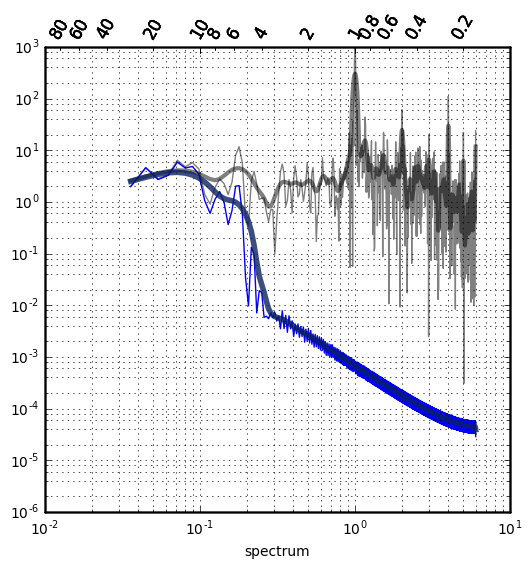

In [4]:
import pyClim.ploTools as ploT

## in order to NOT plot spectrum beyond the spectral resolution imposed by the detrending: i.e. Tc=28 yrs because the total timeseries is 56 yr long
nff = ( np.abs((1./(12.*fff))-28.)).argmin() 

## in order to convert time units from month to year on x axis
motoyr = 12.

       
plt.close('all')  
xlim=[1e-1, 1e1]
ylim=[1e-6, 1e3]  # density

fig = plt.figure(figsize=(6, 6)) 
ax = ploT.subplot(111)

# plot spectrum for inital data 
line1   = ax.spectrum_plot(motoyr*fff[nff:], ppp[nff:], xlog=True, xlim=xlim,ylim=ylim,  ylog=True, lw=1, color="grey",label="dt")

# plot smoothed spectrum for inital data 
line1s  = ax.spectrum_plot(motoyr*fff[nff:], ppp_smoothed[nff:], xlog=True, xlim=xlim,ylim=ylim,  ylog=True, lw=3,alpha=0.5, color="k",label="dt",zorder=10)

# plot spectrum for filtered data
line2   = ax.spectrum_plot(motoyr*fff_filt[nff:], ppp_filt[nff:], xlog=True, xlim=xlim,ylim=ylim,  ylog=True, lw=1, color="b",label="dt_filt")

# plot smoothed spectrum for filtered data
line2s  = ax.spectrum_plot(motoyr*fff_filt[nff:], ppp_filt_smoothed[nff:], xlog=True, xlim=xlim,ylim=ylim,  ylog=True, lw=4,alpha=0.8, color="#0B2161",label="dt_filt",zorder=11)

ax.set_xlabel('spectrum')
plt.show()
fig.savefig('demospectr.pdf')
plt.close('all')  